In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#Installing dependencies
try:
    import music21
except:
    !pip install music21

# try:
#     import lilypond
# except:
#     !pip install lilypond

try: 
    from midi2audio import FluidSynth
except:
    !pip install midi2audio
    from midi2audio import FluidSynth

In [2]:
#Importing Libraries
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [3]:
#Loading the list of chopin's midi files as stream 
filepath = "/home/cyt/Senior Semester 2/Machine Learning/Project/ML_Project_Data/bach/"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

In [4]:
#Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 4145


In [5]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['C4', 'E4', 'G4', 'C5', 'E5', 'G4', 'C5', 'E5', 'C4', 'E4', 'G4', 'C5', 'E5', 'G4', 'C5', 'E5', 'C4', 'D4', 'A4', 'D5', 'F5', 'A4', 'D5', 'F5', 'C4', 'D4', 'A4', 'D5', 'F5', 'A4', 'D5', 'F5', 'B3', 'D4', 'G4', 'D5', 'F5', 'G4', 'D5', 'F5', 'B3', 'D4', 'G4', 'D5', 'F5', 'G4', 'D5', 'F5', 'C4', 'E4']


All these values indicate the notes, as mentioned above.

**Printing the music sheet**

In [6]:
pip install Lilypond

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement Lilypond
ERROR: No matching distribution found for Lilypond
Note: you may need to restart the kernel to use updated packages.


Changing working directory to: `/tmp/music21'
Processing `/tmp/music21/tmp_tgn83nt.ly'
Parsing...
Interpreting music...[8][16][24]
Preprocessing graphical objects...
Calculating line breaks... 
Drawing systems... 
Layout output to `tmp_tgn83nt.ly.eps'...
Converting to PNG...
Layout output to `tmp_tgn83nt.ly-1.eps'...
Layout output to `tmp_tgn83nt.ly-2.eps'...
Layout output to `tmp_tgn83nt.ly-3.eps'...
Writing tmp_tgn83nt.ly-systems.texi...
Writing tmp_tgn83nt.ly-systems.tex...
Writing tmp_tgn83nt.ly-systems.count...
Success: compilation successfully completed


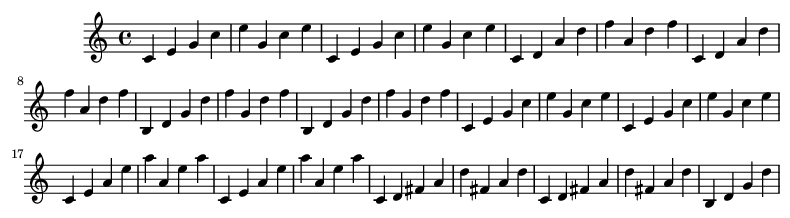

In [7]:
#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
show(Melody_Snippet)

**Playing the above sheet music** 

*As I could not play a midi file on the Kaggle interface, I have created a ".wav" filetype of the same outside of this code. I am using it to create an audio interface. Let us have a listen to the data corpus.* 

In [8]:
#to play audio or corpus
print("Sample Audio From Data")
# IPython.display.Audio("../input/music-generated-lstm/Corpus_Snippet.wav") 

Sample Audio From Data


**Examine all the notes in the Corpus** 

In [9]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 114


In [10]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 36.35964912280702
Most frequent note in Corpus appeared: 226 times
Least frequent note in Corpus appeared: 1 time


Clearly, there are some very rare notes in the melody; some so rare that it was played only once in the whole data. This would create a lot of problems. (I did run into most of them while writing this piece)
To spare us the error reports, let us have a look at the frequency of the notes. 
And for simplicity, I shall be eliminating some of the least occurring notes. I am sure Chopin wouldn't mind me messing with his masterpiece for science or would he? Either way, I may never know!   

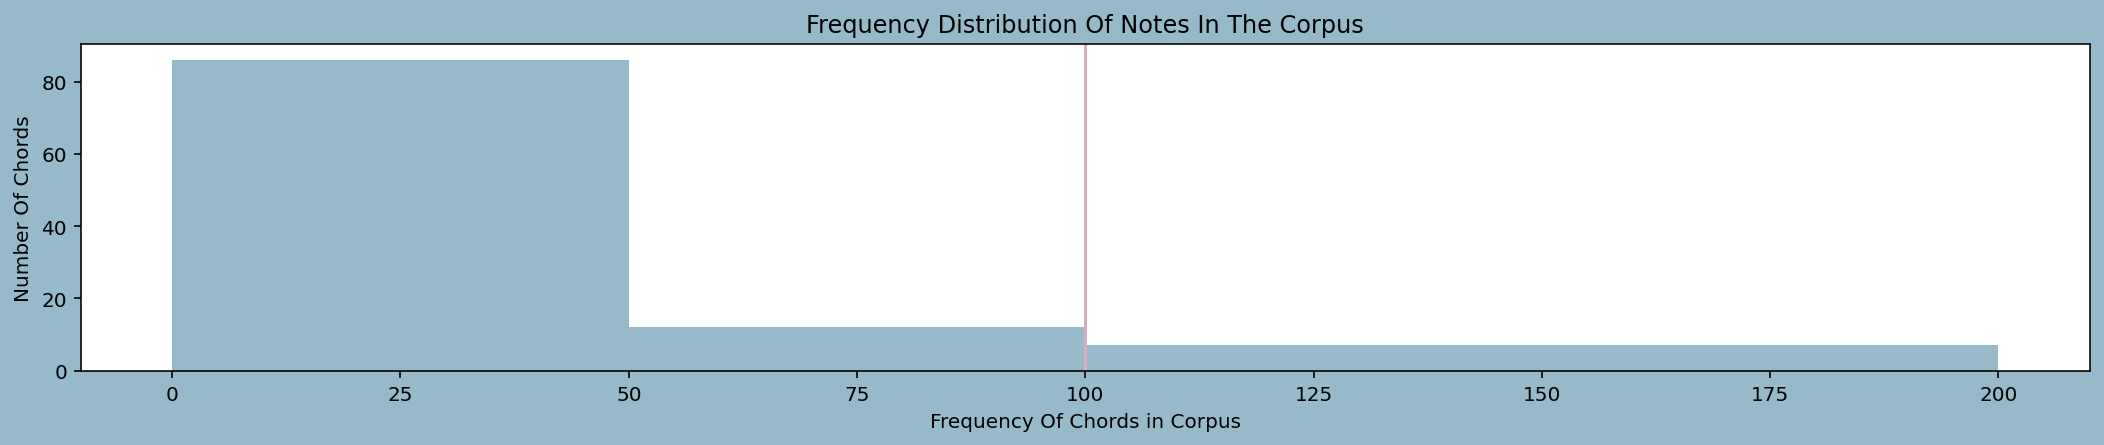

In [11]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

I have decided, I will be taking out the notes that were played less than 100 times. I mean, if Chopin liked them he would have played it a lot more often. So I create a list of rare notes in the next section. 

In [12]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 98


In [13]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 2981


In [14]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 2981
Number of unique characters: 100


**Encoding and Splitting the Corpus as Labels and Targets**

In [15]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 2941


In [16]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

**Splitting Train and Seed datasets**

In [17]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train.shape

(2352, 40, 1)

In [19]:
X_seed.shape

(589, 40, 1)

In [20]:
y_train.shape

(2352, 100)

In [21]:
y_seed.shape

(589, 100)

In [23]:
pip install keras_self_attention

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=2af2cbc25f3b527166cbb554daebd7656c1d41f2a4ca9f5bfe980c5f4f8a32ce
  Stored in directory: /home/cyt/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention
Note: you may need to restart the kernel to use updated packages.


In [24]:
from keras_self_attention import SeqSelfAttention

In [27]:
# model = Sequential()
# model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
# model.add(SeqSelfAttention(attention_activation='softmax',
#         name='Attention'))
# model.add(Dense(256))
# model.add(Dense(y.shape[1], activation='sigmoid'))

In [28]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(SeqSelfAttention(attention_activation='softmax',
        name='Attention'))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [29]:
#Model's Summary               
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 512)           1052672   
                                                                 
 Attention (SeqSelfAttention  (None, 40, 512)          32833     
 )                                                               
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               787456    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

In [30]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=2000)

Epoch 1/2000


2022-05-22 11:36:37.825822: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-05-22 11:36:38.024124: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


10/10 [==============================] - 4s 51ms/step - loss: 4.4016
Epoch 2/2000
10/10 [==============================] - 1s 51ms/step - loss: 3.5435
Epoch 3/2000
10/10 [==============================] - 1s 50ms/step - loss: 3.4612
Epoch 4/2000
10/10 [==============================] - 1s 50ms/step - loss: 3.4505
Epoch 5/2000
10/10 [==============================] - 1s 50ms/step - loss: 3.4519
Epoch 6/2000
10/10 [==============================] - 0s 50ms/step - loss: 3.4459
Epoch 7/2000
10/10 [==============================] - 0s 49ms/step - loss: 3.4489
Epoch 8/2000
10/10 [==============================] - 0s 49ms/step - loss: 3.4431
Epoch 9/2000
10/10 [==============================] - 1s 50ms/step - loss: 3.4311
Epoch 10/2000
10/10 [==============================] - 1s 50ms/step - loss: 3.4363
Epoch 11/2000
10/10 [==============================] - 0s 49ms/step - loss: 3.4431
Epoch 12/2000
10/10 [==============================] - 1s 51ms/step - loss: 3.4372
Epoch 13/2000
10/10 [=====

Epoch 100/2000
10/10 [==============================] - 1s 50ms/step - loss: 3.4129
Epoch 101/2000
10/10 [==============================] - 1s 51ms/step - loss: 3.4101
Epoch 102/2000
10/10 [==============================] - 1s 51ms/step - loss: 3.4104
Epoch 103/2000
10/10 [==============================] - 1s 51ms/step - loss: 3.3913
Epoch 104/2000
10/10 [==============================] - 1s 51ms/step - loss: 3.3896
Epoch 105/2000
10/10 [==============================] - 1s 51ms/step - loss: 3.3846
Epoch 106/2000
10/10 [==============================] - 1s 50ms/step - loss: 3.3746
Epoch 107/2000
10/10 [==============================] - 1s 52ms/step - loss: 3.3745
Epoch 108/2000
10/10 [==============================] - 1s 52ms/step - loss: 3.3551
Epoch 109/2000
10/10 [==============================] - 1s 51ms/step - loss: 3.3830
Epoch 110/2000
10/10 [==============================] - 1s 51ms/step - loss: 3.3527
Epoch 111/2000
10/10 [==============================] - 1s 50ms/step - loss:

10/10 [==============================] - 1s 50ms/step - loss: 1.5042
Epoch 295/2000
10/10 [==============================] - 1s 50ms/step - loss: 1.3329
Epoch 296/2000
10/10 [==============================] - 1s 51ms/step - loss: 1.2069
Epoch 297/2000
10/10 [==============================] - 1s 51ms/step - loss: 1.2248
Epoch 298/2000
10/10 [==============================] - 1s 50ms/step - loss: 1.2804
Epoch 299/2000
10/10 [==============================] - 1s 50ms/step - loss: 1.3254
Epoch 300/2000
10/10 [==============================] - 1s 51ms/step - loss: 1.2675
Epoch 301/2000
10/10 [==============================] - 1s 51ms/step - loss: 1.1879
Epoch 302/2000
10/10 [==============================] - 1s 51ms/step - loss: 1.0913
Epoch 303/2000
10/10 [==============================] - 1s 51ms/step - loss: 1.0862
Epoch 304/2000
10/10 [==============================] - 1s 51ms/step - loss: 1.0087
Epoch 305/2000
10/10 [==============================] - 1s 51ms/step - loss: 1.0671
Epoch 3

10/10 [==============================] - 1s 52ms/step - loss: 0.0018
Epoch 489/2000
10/10 [==============================] - 1s 51ms/step - loss: 0.0015
Epoch 490/2000
10/10 [==============================] - 1s 51ms/step - loss: 0.0015
Epoch 491/2000
10/10 [==============================] - 1s 51ms/step - loss: 0.0014
Epoch 492/2000
10/10 [==============================] - 1s 52ms/step - loss: 0.0014
Epoch 493/2000
10/10 [==============================] - 1s 51ms/step - loss: 0.0014
Epoch 494/2000
10/10 [==============================] - 1s 51ms/step - loss: 0.0015
Epoch 495/2000
10/10 [==============================] - 1s 51ms/step - loss: 0.0012
Epoch 496/2000
10/10 [==============================] - 1s 51ms/step - loss: 0.0013
Epoch 497/2000
10/10 [==============================] - 1s 51ms/step - loss: 0.0012
Epoch 498/2000
10/10 [==============================] - 1s 51ms/step - loss: 0.0011
Epoch 499/2000
10/10 [==============================] - 1s 51ms/step - loss: 0.0010
Epoch 5

Epoch 582/2000
10/10 [==============================] - 1s 51ms/step - loss: 2.7477e-04
Epoch 583/2000
10/10 [==============================] - 1s 51ms/step - loss: 2.6473e-04
Epoch 584/2000
10/10 [==============================] - 1s 51ms/step - loss: 2.8129e-04
Epoch 585/2000
10/10 [==============================] - 1s 51ms/step - loss: 2.3061e-04
Epoch 586/2000
10/10 [==============================] - 1s 51ms/step - loss: 2.5053e-04
Epoch 587/2000
10/10 [==============================] - 1s 51ms/step - loss: 2.6015e-04
Epoch 588/2000
10/10 [==============================] - 1s 51ms/step - loss: 2.3789e-04
Epoch 589/2000
10/10 [==============================] - 1s 51ms/step - loss: 2.2870e-04
Epoch 590/2000
10/10 [==============================] - 1s 51ms/step - loss: 2.2920e-04
Epoch 591/2000
10/10 [==============================] - 1s 53ms/step - loss: 2.3533e-04
Epoch 592/2000
10/10 [==============================] - 1s 51ms/step - loss: 2.2840e-04
Epoch 593/2000
10/10 [==========

10/10 [==============================] - 1s 51ms/step - loss: 3.8127e-04
Epoch 771/2000
10/10 [==============================] - 1s 51ms/step - loss: 3.1315e-04
Epoch 772/2000
10/10 [==============================] - 1s 51ms/step - loss: 2.9377e-04
Epoch 773/2000
10/10 [==============================] - 1s 52ms/step - loss: 2.9275e-04
Epoch 774/2000
10/10 [==============================] - 1s 52ms/step - loss: 2.9928e-04
Epoch 775/2000
10/10 [==============================] - 1s 53ms/step - loss: 2.9688e-04
Epoch 776/2000
10/10 [==============================] - 1s 53ms/step - loss: 2.8781e-04
Epoch 777/2000
10/10 [==============================] - 1s 52ms/step - loss: 2.9219e-04
Epoch 778/2000
10/10 [==============================] - 1s 52ms/step - loss: 2.7299e-04
Epoch 779/2000
10/10 [==============================] - 1s 52ms/step - loss: 2.6865e-04
Epoch 780/2000
10/10 [==============================] - 1s 53ms/step - loss: 2.8235e-04
Epoch 781/2000
10/10 [=========================

10/10 [==============================] - 1s 53ms/step - loss: 7.8278e-04
Epoch 959/2000
10/10 [==============================] - 1s 53ms/step - loss: 7.6196e-04
Epoch 960/2000
10/10 [==============================] - 1s 53ms/step - loss: 6.6499e-04
Epoch 961/2000
10/10 [==============================] - 1s 53ms/step - loss: 6.5025e-04
Epoch 962/2000
10/10 [==============================] - 1s 53ms/step - loss: 6.4875e-04
Epoch 963/2000
10/10 [==============================] - 1s 52ms/step - loss: 6.5047e-04
Epoch 964/2000
10/10 [==============================] - 1s 53ms/step - loss: 6.7231e-04
Epoch 965/2000
10/10 [==============================] - 1s 53ms/step - loss: 6.5130e-04
Epoch 966/2000
10/10 [==============================] - 1s 51ms/step - loss: 5.6804e-04
Epoch 967/2000
10/10 [==============================] - 1s 50ms/step - loss: 5.4890e-04
Epoch 968/2000
10/10 [==============================] - 1s 51ms/step - loss: 5.3722e-04
Epoch 969/2000
10/10 [=========================

10/10 [==============================] - 1s 52ms/step - loss: 0.0263
Epoch 1143/2000
10/10 [==============================] - 1s 52ms/step - loss: 0.0274
Epoch 1144/2000
10/10 [==============================] - 1s 52ms/step - loss: 0.0406
Epoch 1145/2000
10/10 [==============================] - 1s 52ms/step - loss: 0.0297
Epoch 1146/2000
10/10 [==============================] - 1s 52ms/step - loss: 0.0203
Epoch 1147/2000
10/10 [==============================] - 1s 52ms/step - loss: 0.0182
Epoch 1148/2000
10/10 [==============================] - 1s 52ms/step - loss: 0.0207
Epoch 1149/2000
10/10 [==============================] - 1s 53ms/step - loss: 0.0104
Epoch 1150/2000
10/10 [==============================] - 1s 52ms/step - loss: 0.0068
Epoch 1151/2000
10/10 [==============================] - 1s 52ms/step - loss: 0.0053
Epoch 1152/2000
10/10 [==============================] - 1s 52ms/step - loss: 0.0024
Epoch 1153/2000
10/10 [==============================] - 1s 53ms/step - loss: 0.0

10/10 [==============================] - 1s 53ms/step - loss: 1.6687e-04
Epoch 1236/2000
10/10 [==============================] - 1s 51ms/step - loss: 1.6353e-04
Epoch 1237/2000
10/10 [==============================] - 1s 51ms/step - loss: 1.6670e-04
Epoch 1238/2000
10/10 [==============================] - 1s 51ms/step - loss: 1.7896e-04
Epoch 1239/2000
10/10 [==============================] - 1s 52ms/step - loss: 1.6590e-04
Epoch 1240/2000
10/10 [==============================] - 1s 52ms/step - loss: 1.6816e-04
Epoch 1241/2000
10/10 [==============================] - 1s 52ms/step - loss: 1.5495e-04
Epoch 1242/2000
10/10 [==============================] - 1s 52ms/step - loss: 1.5294e-04
Epoch 1243/2000
10/10 [==============================] - 1s 52ms/step - loss: 1.6659e-04
Epoch 1244/2000
10/10 [==============================] - 1s 52ms/step - loss: 1.5535e-04
Epoch 1245/2000
10/10 [==============================] - 1s 52ms/step - loss: 1.5113e-04
Epoch 1246/2000
10/10 [==============

10/10 [==============================] - 1s 52ms/step - loss: 2.7543e-05
Epoch 1420/2000
10/10 [==============================] - 1s 52ms/step - loss: 2.2315e-05
Epoch 1421/2000
10/10 [==============================] - 1s 52ms/step - loss: 2.2563e-05
Epoch 1422/2000
10/10 [==============================] - 1s 52ms/step - loss: 2.4064e-05
Epoch 1423/2000
10/10 [==============================] - 1s 54ms/step - loss: 1.9696e-05
Epoch 1424/2000
10/10 [==============================] - 1s 54ms/step - loss: 2.2981e-05
Epoch 1425/2000
10/10 [==============================] - 1s 54ms/step - loss: 2.2188e-05
Epoch 1426/2000
10/10 [==============================] - 1s 54ms/step - loss: 2.2696e-05
Epoch 1427/2000
10/10 [==============================] - 1s 52ms/step - loss: 2.4544e-05
Epoch 1428/2000
10/10 [==============================] - 1s 52ms/step - loss: 1.9661e-05
Epoch 1429/2000
10/10 [==============================] - 1s 52ms/step - loss: 2.2111e-05
Epoch 1430/2000
10/10 [==============

10/10 [==============================] - 1s 52ms/step - loss: 3.6539e-06
Epoch 1604/2000
10/10 [==============================] - 1s 53ms/step - loss: 3.7032e-06
Epoch 1605/2000
10/10 [==============================] - 1s 52ms/step - loss: 3.7138e-06
Epoch 1606/2000
10/10 [==============================] - 1s 52ms/step - loss: 3.9300e-06
Epoch 1607/2000
10/10 [==============================] - 1s 51ms/step - loss: 3.4782e-06
Epoch 1608/2000
10/10 [==============================] - 1s 52ms/step - loss: 4.0450e-06
Epoch 1609/2000
10/10 [==============================] - 1s 52ms/step - loss: 4.0994e-06
Epoch 1610/2000
10/10 [==============================] - 1s 52ms/step - loss: 3.6666e-06
Epoch 1611/2000
10/10 [==============================] - 1s 52ms/step - loss: 3.7123e-06
Epoch 1612/2000
10/10 [==============================] - 1s 52ms/step - loss: 3.3973e-06
Epoch 1613/2000
10/10 [==============================] - 1s 54ms/step - loss: 3.1720e-06
Epoch 1614/2000
10/10 [==============

10/10 [==============================] - 1s 53ms/step - loss: 3.3536e-04
Epoch 1697/2000
10/10 [==============================] - 1s 52ms/step - loss: 3.2283e-04
Epoch 1698/2000
10/10 [==============================] - 1s 53ms/step - loss: 3.2681e-04
Epoch 1699/2000
10/10 [==============================] - 1s 53ms/step - loss: 2.8489e-04
Epoch 1700/2000
10/10 [==============================] - 1s 52ms/step - loss: 3.2742e-04
Epoch 1701/2000
10/10 [==============================] - 1s 53ms/step - loss: 2.6713e-04
Epoch 1702/2000
10/10 [==============================] - 1s 53ms/step - loss: 2.5810e-04
Epoch 1703/2000
10/10 [==============================] - 1s 54ms/step - loss: 2.7874e-04
Epoch 1704/2000
10/10 [==============================] - 1s 53ms/step - loss: 2.6525e-04
Epoch 1705/2000
10/10 [==============================] - 1s 53ms/step - loss: 2.5138e-04
Epoch 1706/2000
10/10 [==============================] - 1s 53ms/step - loss: 2.7806e-04
Epoch 1707/2000
10/10 [==============

10/10 [==============================] - 1s 52ms/step - loss: 3.4642e-05
Epoch 1881/2000
10/10 [==============================] - 1s 52ms/step - loss: 3.6580e-05
Epoch 1882/2000
10/10 [==============================] - 1s 52ms/step - loss: 3.5918e-05
Epoch 1883/2000
10/10 [==============================] - 1s 52ms/step - loss: 3.3240e-05
Epoch 1884/2000
10/10 [==============================] - 1s 52ms/step - loss: 3.1280e-05
Epoch 1885/2000
10/10 [==============================] - 1s 52ms/step - loss: 3.1803e-05
Epoch 1886/2000
10/10 [==============================] - 1s 52ms/step - loss: 3.4339e-05
Epoch 1887/2000
10/10 [==============================] - 1s 52ms/step - loss: 3.1479e-05
Epoch 1888/2000
10/10 [==============================] - 1s 52ms/step - loss: 3.0715e-05
Epoch 1889/2000
10/10 [==============================] - 1s 52ms/step - loss: 3.1733e-05
Epoch 1890/2000
10/10 [==============================] - 1s 52ms/step - loss: 3.3085e-05
Epoch 1891/2000
10/10 [==============

[Text(0.5, 0, 'Epochs')]

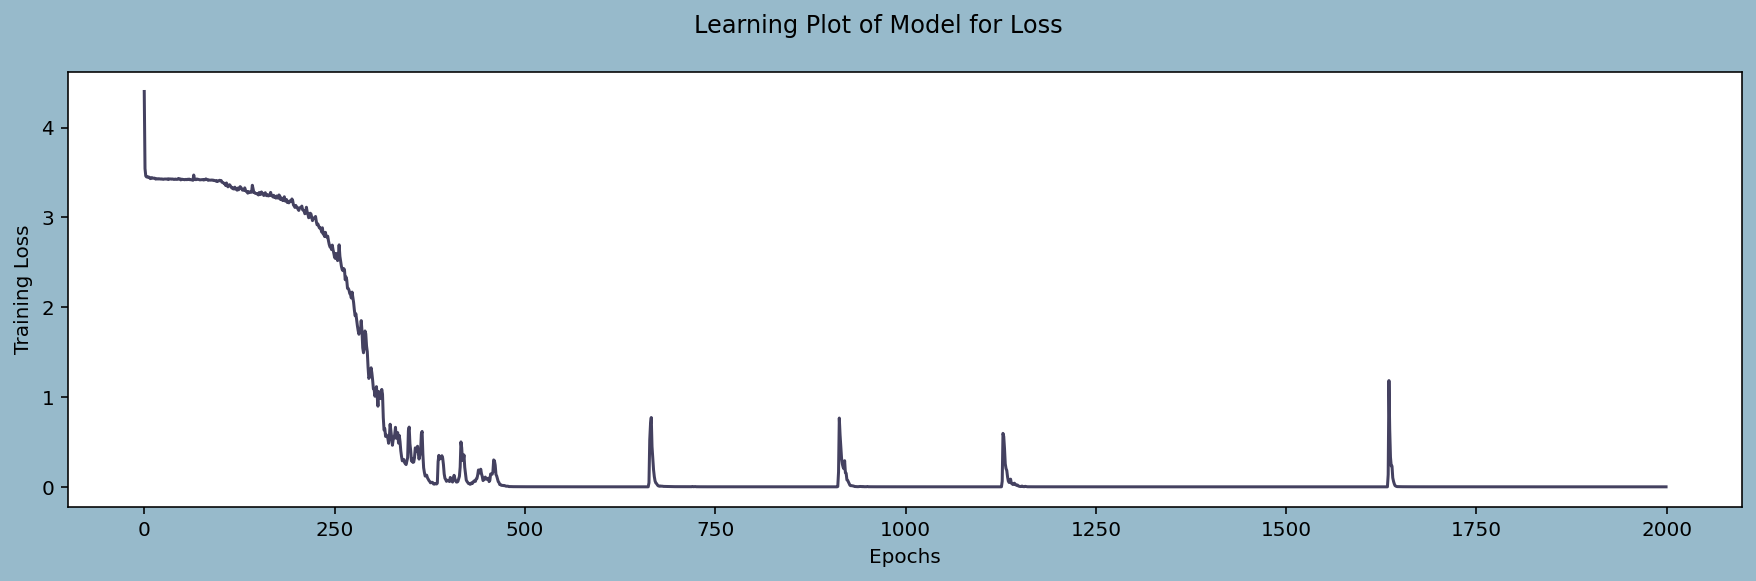

In [31]:
#Plotting the learnings 
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

**Generating the Melody**

A function to obtain the generated music

Changing working directory to: `/tmp/music21'
Processing `/tmp/music21/tmptak6efbm.ly'
Parsing...
Interpreting music...[8][16][24]
Preprocessing graphical objects...
Calculating line breaks... 
Drawing systems... 
Layout output to `tmptak6efbm.ly.eps'...
Converting to PNG...
Layout output to `tmptak6efbm.ly-1.eps'...
Layout output to `tmptak6efbm.ly-2.eps'...
Layout output to `tmptak6efbm.ly-3.eps'...
Writing tmptak6efbm.ly-systems.texi...
Writing tmptak6efbm.ly-systems.tex...
Writing tmptak6efbm.ly-systems.count...
Success: compilation successfully completed


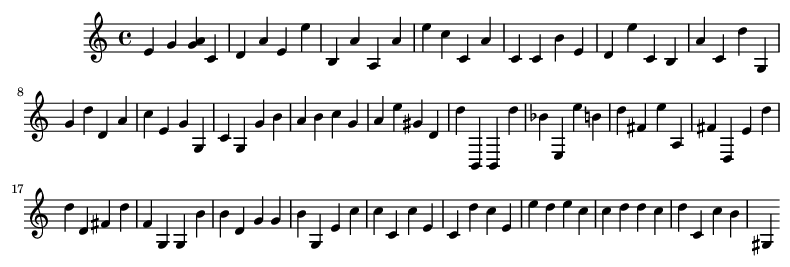

In [32]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(100)
show(Melody)